In [14]:
# Standard libraries
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "neuronal-sequence-test"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from scipy.stats import mannwhitneyu, binom
rstest_twosided = lambda x, y : mannwhitneyu(x, y, alternative='two-sided')

# User libraries
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.stat.machinelearning import binary_classifier
from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.stat.connectomics import offdiag_1D

from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
import src.lib.plots_pca as plots_pca
from src.lib.metric_wrapper import metric_by_selector
from src.lib.extra_metrics import num_non_zero_std, num_sample

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/neuronal-sequence-test
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'

In [11]:
dataDB = BehaviouralNeuronalDatabase(params)

In [12]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [13]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


# 1. Neuron-Time-Average

**Goal**: Attempt to predict L/R and C/M from mean activity over trial

No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping


,mouse,L,R,nTrials,pval
0,m060,0.075506,0.072988,"(79, 74)",0.295568
1,m061,0.111088,0.107360,"(45, 45)",0.361834
2,m065,0.122184,0.126791,"(122, 116)",0.037661
3,m066,0.137803,0.134030,"(86, 102)",0.375362
4,m067,0.116903,0.116561,"(90, 107)",0.843881
5,m068,0.082342,0.085399,"(126, 112)",0.174733


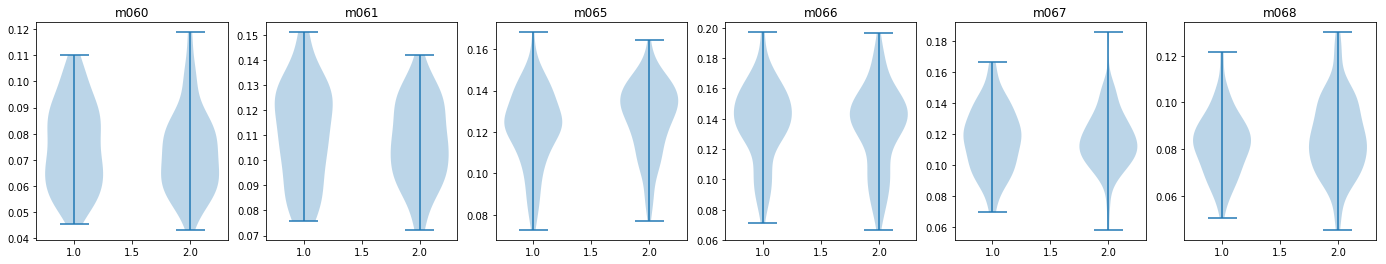

In [15]:
def test_mean_time_and_neurons(dataDB, datatype, selector, condition):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    testResults = []
    
    fig, ax = plt.subplots(ncols=nMice, figsize=(4*nMice, 4))
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:        
            queryDictCond = {"datatype" : datatype, "mousename" : mousename, condition : condVal}
            means += [metric_by_selector(dataDB, queryDictCond, "mean", "r", selector, {})]

        testResults += [[mousename, *[np.mean(mu) for mu in means], tuple(len(mu) for mu in means), rstest_twosided(*means)[1]]]
        ax[iMouse].violinplot(means)
        ax[iMouse].set_title(mousename)
        
    display(pd.DataFrame(testResults, columns=["mouse", *condValues, "nTrials", "pval"]))
    plt.show()
    
    
test_mean_time_and_neurons(dataDB, "deconv", {"phase" : "Maintenance"}, "direction")
#test_mean_time_and_neurons(dataDB, "raw", {"interval" : 8}, "performance")

# 2 Time-Average

**Goal**: Attempt to predict LR/CM from average activities of individual cells.
* Count predictive cells in each mouse, phase/interval

,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,16,88,15.1
1,m061,0,46,0.0
2,m065,5,83,2.8
3,m066,3,47,1.9
4,m067,0,49,0.0
5,m068,1,28,0.6


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


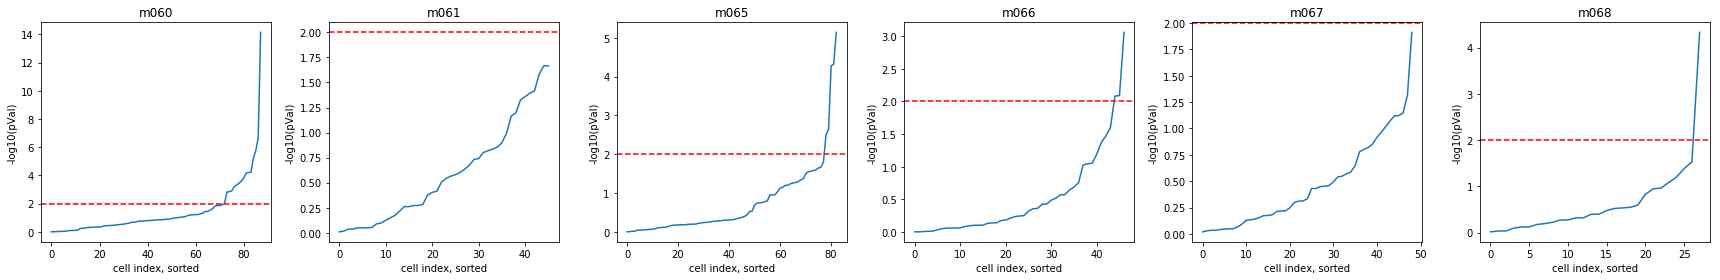

In [16]:
def test_mean_time(dataDB, queryDict, selector, condition, nTest=1000, pval=0.01):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    fig1, ax1 = plt.subplots(ncols=nMice, figsize=(4*nMice, 4), tight_layout=True)
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:
            queryDictCond = {**queryDict, **{"mousename" : mousename, condition : condVal}}
            means += [metric_by_selector(dataDB, queryDictCond, "mean", "rp", selector, {})]
            
        nCells = means[0].shape[1]
        pValByCell = [rstest_twosided(means[0][:, iCell], means[1][:, iCell])[1] for iCell in range(nCells)]

        ax1[iMouse].plot(sorted(-np.log10(pValByCell)))
        ax1[iMouse].axhline(y=2, linestyle="--", color='r')
        ax1[iMouse].set_xlabel("cell index, sorted")
        ax1[iMouse].set_ylabel("-log10(pVal)")
        ax1[iMouse].set_title(mousename)
        
        binomPMF = binom.pmf(np.arange(0, nCells), nCells, pval)
        nCellSignificant = np.sum(np.array(pValByCell) < pval)
        pValPop = np.sum(binomPMF[nCellSignificant:])
        negLogPValPop = np.round(-np.log10(pValPop), 1)
        
        mouseResults += [[mousename, nCellSignificant, nCells, negLogPValPop]]
        
    display(pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "pvalPopulation"]))
        
    plt.show()
    
    
queryDict = {"datatype" : "deconv", "performance" : "Correct"}
#queryDict = {"datatype" : "deconv", "direction" : "L"}
test_mean_time(dataDB, queryDict, {"interval" : 5}, "direction")
#test_mean_time(dataDB, queryDict, {"phase" : "Maintenance"}, "direction")

Calculating mouse m060
Calculating mouse m061
Calculating mouse m065
Calculating mouse m066
Calculating mouse m067
Calculating mouse m068


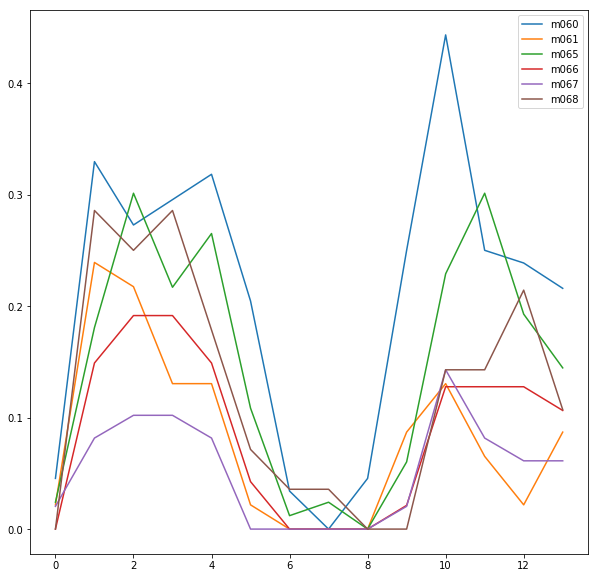

In [17]:
def test_ncells_by_interval(dataDB, queryDict, condition, intervRange, nTest=1000, pval=0.01):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    fig, ax = plt.subplots(figsize=(10,10))
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Calculating mouse", mousename)
        
        freqCellSignificant = []
        for iInterv in intervRange:
            selector = {"interval" : iInterv}
        
            means = []
            for condVal in condValues:        
                queryDictCond = {**queryDict, **{"mousename" : mousename, condition : condVal}}
                means += [metric_by_selector(dataDB, queryDictCond, "mean", "rp", selector, {})]

            nCells = means[0].shape[1]
            pValByCell = [rstest_twosided(means[0][:, iCell], means[1][:, iCell])[1] for iCell in range(nCells)]
            nCellSignificant = np.sum(np.array(pValByCell) < pval)
            freqCellSignificant += [nCellSignificant / nCells]
            
        ax.plot(intervRange, freqCellSignificant, label=mousename)

    plt.legend()
    plt.show()
    
queryDict = {"datatype" : "deconv", "performance" : "Correct"}
test_ncells_by_interval(dataDB, queryDict, "direction", range(0, 14))

# 3. Scalar metric tests

**Goal**: Evaluate predictive power for several metrics
* Stretch hypothesis: Legendre Basis (try several bases individually up to 6)
* Synchronization hypothesis: AvgCorr, H

## Table [TODO]

In [25]:
%%time
dataDB.verbose = False

#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}
settings = {"serial" : True, "metricSettings" : {"max_lag" : 1}}
sweepDict = {
    "datatype": ["raw", "high", "deconv"],
    "performance": ["Correct", "Mistake", "All"],
#    "direction": ["L", "R", "All"]
}

plots_lib.table_discriminate_behavior(dataDB, {"phase" : "Maintenance"}, "direction",
                                      sweepDict,
                                      "mean",
                                      trgDimOrder="r",
                                      settings=settings)

{'datatype': 'raw', 'performance': 'Correct', 'direction': 'L'}
434
{'datatype': 'raw', 'performance': 'Mistake', 'direction': 'L'}
114
{'datatype': 'raw', 'direction': 'L'}
548
{'datatype': 'high', 'performance': 'Correct', 'direction': 'L'}
434
{'datatype': 'high', 'performance': 'Mistake', 'direction': 'L'}
114
{'datatype': 'high', 'direction': 'L'}
548
{'datatype': 'deconv', 'performance': 'Correct', 'direction': 'L'}
434
{'datatype': 'deconv', 'performance': 'Mistake', 'direction': 'L'}
114
{'datatype': 'deconv', 'direction': 'L'}
548
{'datatype': 'raw', 'performance': 'Correct', 'direction': 'R'}
434
{'datatype': 'raw', 'performance': 'Mistake', 'direction': 'R'}
122
{'datatype': 'raw', 'direction': 'R'}
556
{'datatype': 'high', 'performance': 'Correct', 'direction': 'R'}
434
{'datatype': 'high', 'performance': 'Mistake', 'direction': 'R'}
122
{'datatype': 'high', 'direction': 'R'}
556
{'datatype': 'deconv', 'performance': 'Correct', 'direction': 'R'}
434
{'datatype': 'deconv', '

,datatype,performance,L,R,"-logp(0, 1)",nTrial
0,raw,Correct,-0.062564,1.087264,1.53,"[[434, 434]]"
1,raw,Mistake,-1.313203,0.717772,1.41,"[[114, 122]]"
2,raw,All,-0.322734,1.006188,2.24,"[[548, 556]]"
3,high,Correct,-0.014713,-0.014448,0.31,"[[434, 434]]"
4,high,Mistake,-0.028745,-0.004810,2.03,"[[114, 122]]"
5,high,All,-0.017632,-0.012333,0.86,"[[548, 556]]"
6,deconv,Correct,0.107268,0.109687,0.99,"[[434, 434]]"
7,deconv,Mistake,0.105821,0.106915,0.42,"[[114, 122]]"
8,deconv,All,0.106967,0.109079,1.02,"[[548, 556]]"


CPU times: user 1.93 s, sys: 12.3 ms, total: 1.95 s
Wall time: 1.93 s


## Violins

For ('Correct', 'Mistake') of data size (434, 114) rank-sum-test is 0.0007104739231471268


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


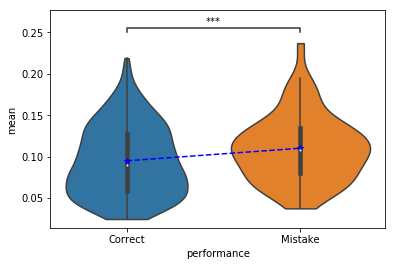

In [20]:
def binary_test_phase(dataDB, queryDict, condition, selector, metricName, settings):
    condValues = list(set(dataDB.metaDataFrames['behaviorStates'][condition]))
    
    rezLst = []
    for condVal in condValues:
        queryDictCond = {**queryDict, **{condition : condVal}}
        rezLst += [metric_by_selector(dataDB, queryDictCond, metricName, "r", selector, {})]
        
    fig, ax = plt.subplots()
    plots_lib.plot_labeled_violins(ax, rezLst, condValues, condition, metricName,
                                   joinMeans=True, haveLog=False, sigTestPairs=[(0,1)])
    
    
#settings = {"serial" : True, "metricSettings" : {"metric" : num_sample}}
settings = {"serial" : True, "metricSettings" : {}}
queryDict = {"datatype" : "deconv", "direction" : "L"}

binary_test_phase(dataDB, queryDict, "performance", {"interval" : 8}, "mean", settings)
#binary_test_phase(dataDB, queryDict, "direction", ["L", "R"], "Maintenance", settings)

# 4. Binary Classification

**Goal**: Train a classifier to discriminate between two cases (L/R), (C/M)

**Versions**:
* **4A. Mouse-wise**: Choose metric that is independent of number of samples, calc individually for each mouse
* **4B. All-mice**: Choose metric that has fixed shape per trial, calc for all mice

**Advantages**:
* Can theoretically make use of vector metrics, by studying their combinations

**Problems**:
* High overfitting. Performance for train and test dramatically different.

**TODO**:
* Research further into regularization. Try more sophisticated estimators (e.g. )
* Impl classification by phase

In [3]:
# 4B
queryDict = {"direction": "L", "datatype": "raw"}
#queryDict = {"performance": "Correct", "datatype": "raw"}
settings = {"serial": True, "metricSettings": None}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}

rez = plots_lib.table_binary_classification(dataDB, "Maintenance", "performance", "cumul_ord_coeff", "",
                                            queryDict, settings)

rez

NameError: name 'plots_lib' is not defined

In [ ]:
# 4A
queryDict = {"performance": "Correct", "datatype": "raw"}
#queryDict = {"direction": "L", "datatype": "high"}
settings = {"serial": True, "metricSettings": {"lag" : 1, "max_lag" : 3}}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}

plots_lib.table_binary_classification_bymouse(dataDB, "Maintenance", "direction", "temporal_basis", "rp",
                                              queryDict, settings)